In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime
def hour_cut(x):
    if 0<=x<6:
        return 0
    elif  6<=x<8:
        return 1
    elif  8<=x<12:
        return 2
    elif  12<=x<14:
        return 3
    elif  14<=x<18:
        return 4
    elif  18<=x<21:
        return 5
    elif  21<=x<24:
        return 6

#出生的年代
def birth_split(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7
    else:
        return 8
#收入分组
def income_cut(x):
    if x<0:
        return 0
    elif  0<=x<1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<24000:
        return 3
    elif  24000<x<40000:
        return 4
    elif  40000<=x:
        return 5
    else:
        return 6

In [2]:
drop_unlabeled = False
preprocess_data_dir = Path('preprocess_data.ipynb').parent / 'preprocess_data'
preprocess_data_dir.mkdir(parents=True, exist_ok=True)
figirue_dir = Path('preprocess_data.ipynb').parent / 'figure'
figirue_dir.mkdir(parents=True, exist_ok=True)
#导入数据
train_abbr=pd.read_csv("raw_data/happiness_train_abbr.csv",encoding='ISO-8859-1')
train=pd.read_csv("raw_data/happiness_train_complete.csv",encoding='ISO-8859-1')
test_abbr=pd.read_csv("raw_data/happiness_test_abbr.csv",encoding='ISO-8859-1')
test=pd.read_csv("raw_data/happiness_test_complete.csv",encoding='ISO-8859-1')
test_sub=pd.read_csv("raw_data/happiness_submit.csv",encoding='ISO-8859-1')

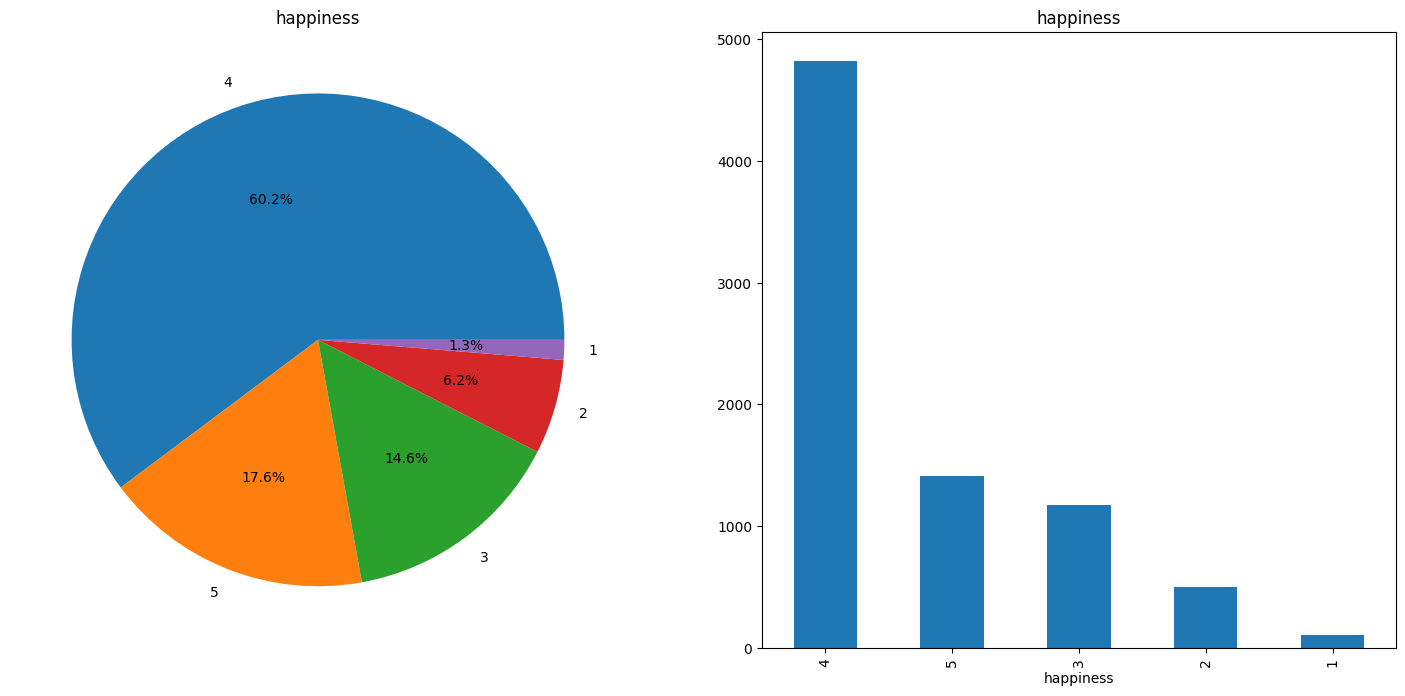

In [3]:
# 绘制缺失指标缺失比图

# y_train_ = train['happiness']
# 绘制label分布

# 根据label分布，观察到 -8值， 应该是缺失值，将其替换为中等幸福水平3
if drop_unlabeled:
    # y_train_ = y_train_.loc[y_train_ != -8]
    train = train.loc[train['happiness'] != -8]
else:
    train['happiness'] = train['happiness'].map(lambda x: 3 if x == -8 else x)
    # y_train_ = y_train_.map(lambda x: 3 if x == -8 else x)

y_train_ = train['happiness']

# 让label从0开始
y_train_ = y_train_.map(lambda x: x - 1)

# 查看各个类别的分布情况 #
f,ax=plt.subplots(1,2,figsize=(18,8))
train['happiness'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('happiness')
ax[0].set_ylabel('')
train['happiness'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('happiness')
plt.show()
# plt.savefig(figirue_dir / 'happiness_distribution.png')


<Axes: >

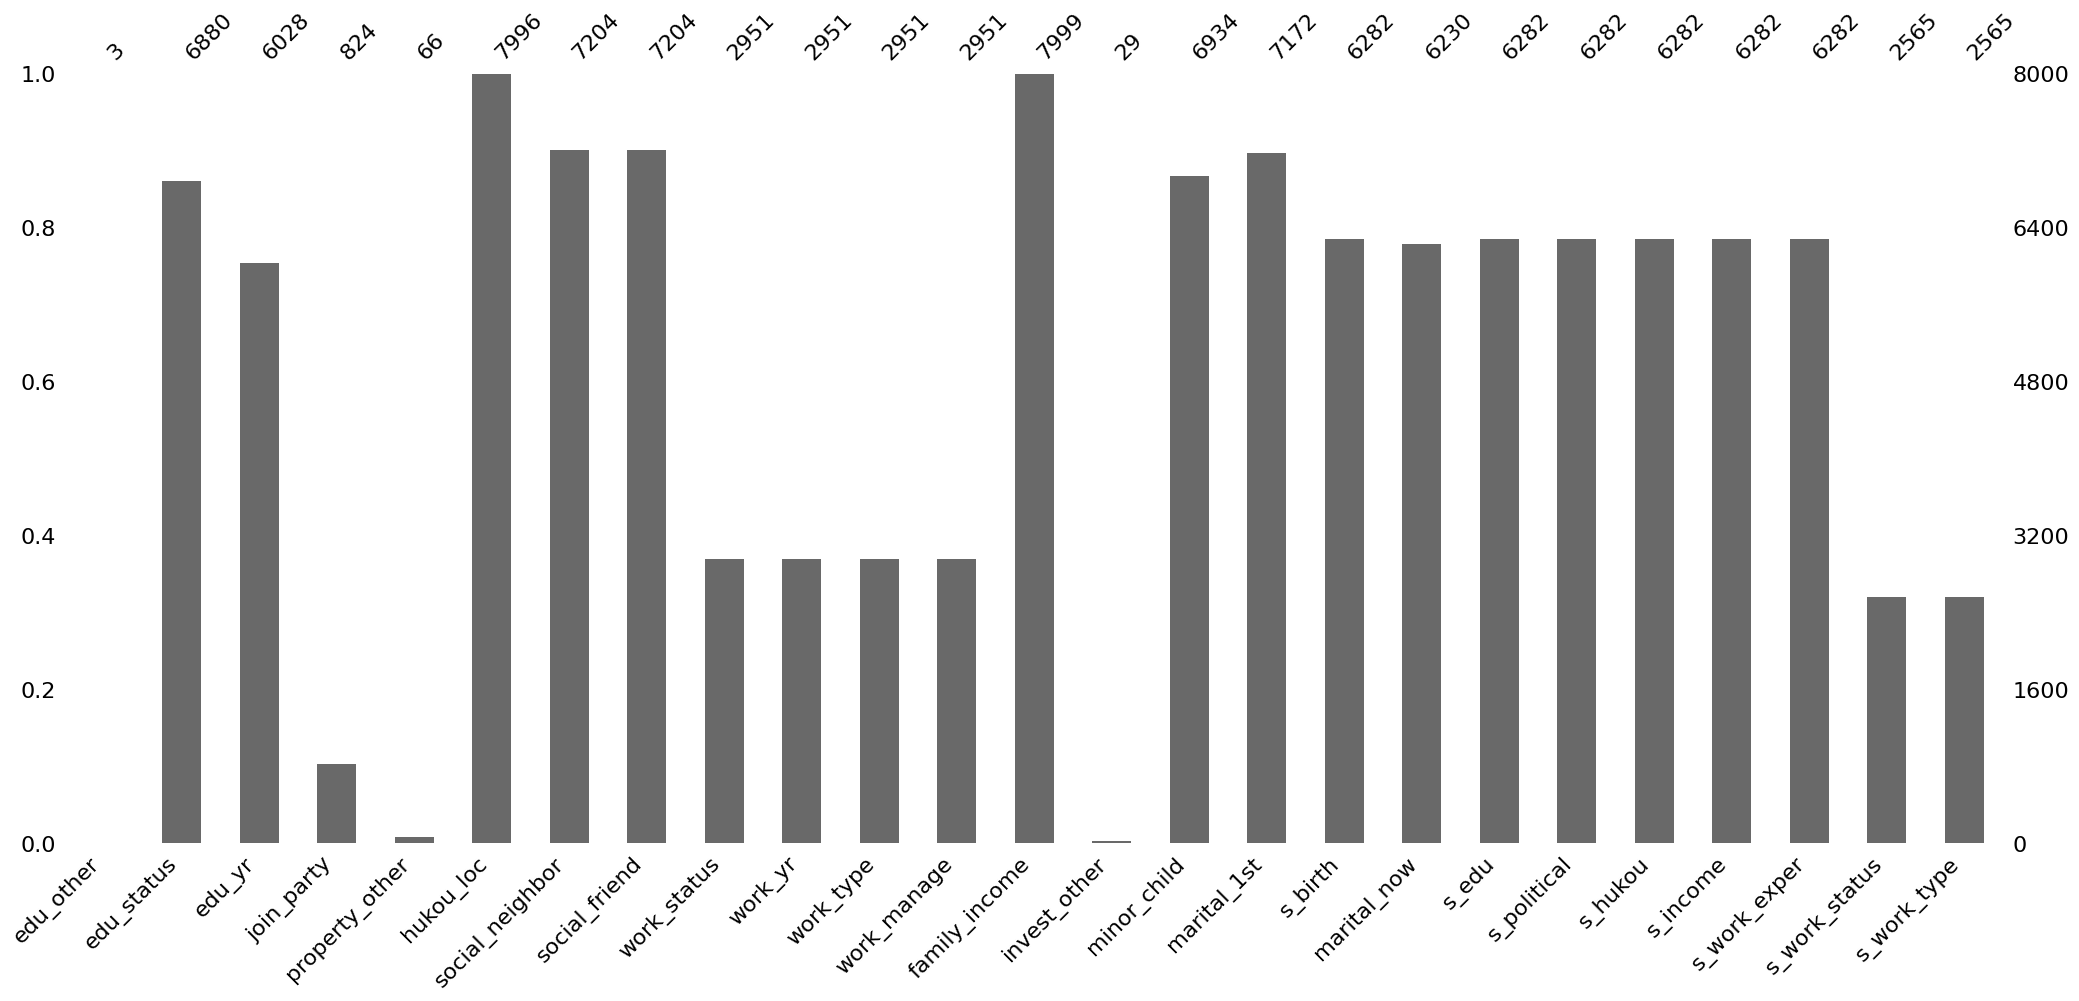

In [10]:
import missingno as msm
missing_percentage = train.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter out columns with no missing values
missing_train = train[missing_percentage.index]
msm.bar(missing_train)


In [4]:
# 一起预处理
data = pd.concat([train, test], axis=0, ignore_index=True)


# 数据处理
# 1. 处理时间特征
data['survey_time'] = pd.to_datetime(data['survey_time'],format='%Y/%m/%d %H:%M')
data["weekday"]=data["survey_time"].dt.weekday
data["year"]=data["survey_time"].dt.year
data["quarter"]=data["survey_time"].dt.quarter
data["hour"]=data["survey_time"].dt.hour
data["month"]=data["survey_time"].dt.month
data['survey_time'] = data['survey_time'].map(lambda x: x.value//10**6)
# 2. 数据分段
# 2.1 一天的hour
data["hour_cut"]=data["hour"].map(hour_cut)
# 2.2 出生的年代
data["birth_s"]=data["birth"].map(birth_split)
# 2.3 收入水平
data["income_cut"]=data["income"].map(income_cut)

# 2. 做问卷时候的年龄
data["survey_age"]=data["year"]-data["birth"]

# 3. 去掉过多的缺失值
data=data.drop(["edu_other"], axis=1)
data=data.drop(["happiness"], axis=1)
data=data.drop(["survey_time"], axis=1)
# data = data.select_dtypes(include=[np.number])
# 填充数据
# for col in data.columns:
#     positive_median = data[col][data[col] > 0].median()
#     data[col] = np.where(data[col] < 0, positive_median, data[col])
    

# 4. 填充数据
data["edu_status"]=data["edu_status"].fillna(5)
data["edu_yr"]=data["edu_yr"].fillna(-2)

data["property_other"]=data["property_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["hukou_loc"]=data["hukou_loc"].fillna(1)
# data["hukou_loc"]=data["hukou_loc"].fillna(5)

data["social_neighbor"]=data["social_neighbor"].fillna(8)
data["social_friend"]=data["social_friend"].fillna(8)

data["work_status"]=data["work_status"].fillna(0)
data["work_yr"]=data["work_yr"].fillna(0)
data["work_type"]=data["work_type"].fillna(0)
data["work_manage"]=data["work_manage"].fillna(0)

# family_income_median = data['family_income'][data['family_income'] > 0].median()
# data["family_income"]=data["family_income"].fillna(family_income_median)

data["family_income"] = data["family_income"].fillna(-2)

data["invest_other"]=data["invest_other"].map(lambda x:0 if pd.isnull(x)  else 1)

data["minor_child"]=data["minor_child"].fillna(0)

# 存疑
data["marital_1st"]=data["marital_1st"].fillna(0)
data["s_birth"]=data["s_birth"].fillna(0)
data["marital_now"]=data["marital_now"].fillna(0)

data["s_edu"]=data["s_edu"].fillna(0)
data["s_political"]=data["s_political"].fillna(0)
data["s_hukou"]=data["s_hukou"].fillna(0)
data["s_income"]=data["s_income"].fillna(0)
data["s_work_exper"]=data["s_work_exper"].fillna(0)
data["s_work_status"]=data["s_work_status"].fillna(0)
data["s_work_type"]=data["s_work_type"].fillna(0)


# 去掉id
data=data.drop(["id"], axis=1)
data = data.drop(["survey_age", "property_other", "invest_other", "join_party"], axis=1)


In [5]:
test_data.shape, train_data.shape

((500, 140), (7500, 140))

In [5]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_train = data[:train.shape[0]]
y_train = y_train_
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

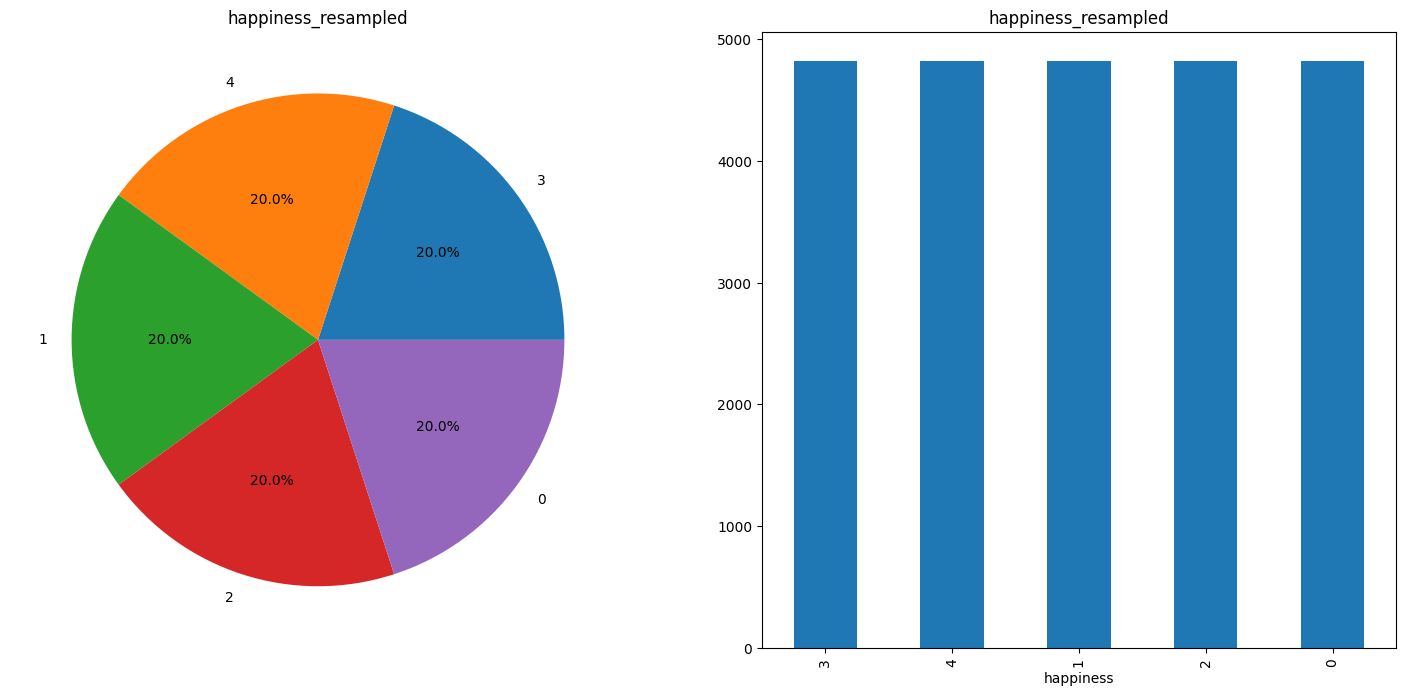

In [6]:
# 查看各个类别的分布情况 #
f,ax=plt.subplots(1,2,figsize=(18,8))
y_train_resampled.value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('happiness_resampled')
ax[0].set_ylabel('')
y_train_resampled.value_counts().plot.bar(ax=ax[1])
ax[1].set_title('happiness_resampled')
plt.show()
# plt.savefig(figirue_dir / 'happiness_distribution.png')

In [9]:
print(y_train_resampled.shape)
print(y_train_.shape)

(24090,)
(8000,)


In [7]:
import missingno as msm
missing_percentage = x_train.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter out columns with no missing values
# missing_train = train[missing_percentage.index]
# msm.bar(missing_train)
print(missing_percentage)

join_party    89.7
income_cut     2.8
dtype: float64


In [5]:
data.head()

,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,weekday,year,quarter,hour,month,hour_cut,birth_s,income_cut
0,1,12,32,59,1,1959,1,1,1,11,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,0.0,0.0,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60.0,50,50,30.0,30,50,50,50,1,2015,3,14,8,4,3,3.0
1,2,18,52,85,1,1992,1,1,1,12,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,0,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70.0,70,80,85.0,70,90,60,60,1,2015,3,15,7,4,7,3.0
2,2,29,83,126,2,1967,1,0,3,4,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,0.0,0.0,0.0,0.0,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,0.0,0.0,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80.0,75,79,80.0,90,90,90,75,1,2015,3,13,7,3,4,2.0
3,2,10,28,51,2,1943,1,1,1,3,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,0.0,0.0,0.0,0.0,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,1,4,0.0,7,1960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90.0,70,80,80.0,90,90,80,80,5,2015,3,17,7,4,2,2.0
4,1,7,18,36,2,1994,1,1,1,12,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,0.0,0.0,0.0,0.0,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,0,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50.0,50,50,50.0,50,50,50,50,0,2015,3,9,8,2,7,0.0


In [6]:
data.tail()

,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,weekday,year,quarter,hour,month,hour_cut,birth_s,income_cut
10963,1,27,77,117,2,1946,1,1,1,3,2.0,-2.0,1720,1,NaN,45.0,0,0,0,0,0,0,0,0,1,170,150,1,3,3,1,2.0,2,2,3,4,1,1,1,5,5,5,5,4,4,5,4,5,4,5,4,4,2,1.0,1.0,1,5,8,8,10,7,1,3.0,6.0,1.0,3.0,1,2,2,2,-2.0,2,2,7,2,0,1,0,0,0,0,0,0,0,2,0,2.0,7,1982.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1932,3,1,2,1925,2,1,2,1,1,4,3,10000.0,4,4,4,4,3,5,5,5,5,5,5,5,2,5,50,60.0,60,70,50.0,60,40,60,50,6,2015,3,20,7,5,2,2.0
10964,2,26,74,114,2,1977,1,1,1,4,2.0,-1.0,10000,1,NaN,600.0,0,1,0,0,0,0,0,0,0,150,100,4,4,3,1,1.0,1,1,1,4,1,1,1,4,4,5,5,4,4,5,5,5,5,5,3,1,1,3.0,4.0,4,3,4,3,5,1,3,0.0,0.0,0.0,0.0,1,2,2,2,20000.0,4,3,1,2,0,1,0,0,0,0,0,0,0,1,1,2.0,3,1998.0,1975.0,1998.0,3.0,1.0,1.0,10000.0,3.0,0.0,0.0,-2,1,1,2,-2,1,1,2,2,1,3,2,-2.0,4,4,4,3,3,2,2,1,1,1,1,1,1,3,60,50.0,70,50,50.0,50,50,50,50,5,2015,3,13,8,3,5,2.0
10965,2,29,84,127,2,1968,1,1,1,1,5.0,-2.0,15000,1,NaN,100.0,0,0,1,0,0,0,0,0,0,165,110,2,3,4,1,1.0,1,1,1,4,1,1,1,3,3,5,5,4,4,5,5,5,5,5,2,3,1,2.0,2.0,1,4,5,1,7,2,3,0.0,0.0,0.0,0.0,1,1,2,2,30000.0,2,3,1,2,0,1,0,0,0,0,0,0,0,0,3,0.0,3,1989.0,1962.0,1989.0,4.0,1.0,1.0,15000.0,3.0,0.0,0.0,-2,1,1,2,-2,1,1,2,2,1,4,2,20000.0,4,4,4,4,4,-8,-8,-8,2,-8,-8,-8,2,4,60,60.0,60,60,60.0,60,60,60,60,2,2015,3,9,7,2,4,3.0
10966,1,11,31,54,1,1950,1,1,1,7,4.0,-2.0,-1,1,NaN,130.0,0,1,0,0,0,0,0,0,0,168,120,4,5,5,1,1.0,1,1,1,5,1,1,1,5,5,5,5,5,5,5,5,5,5,5,1,2,2,8.0,8.0,1,2,2,1,2,2,4,0.0,0.0,0.0,0.0,1,1,2,2,-1.0,2,3,1,2,0,1,0,0,0,0,0,0,0,1,1,0.0,3,1988.0,1950.0,1988.0,7.0,1.0,-8.0,-1.0,4.0,0.0,0.0,-2,1,1,2,-2,1,1,2,2,1,4,-8,-3.0,5,5,5,5,5,5,5,5,5,5,5,5,5,3,84,60.0,70,87,90.0,80,80,80,80,0,2015,3,16,7,4,2,0.0
10967,1,13,37,68,1,1941,1,1,1,4,2.0,1954.0,12000,1,NaN,135.0,0,1,1,0,0,0,0,0,0,164,110,5,5,5,2,1.0,4,2,1,4,1,1,1,5,5,2,5,4,4,5,4,5,5,5,4,4,3,2.0,5.0,1,5,8,6,8,1,5,0.0,0.0,0.0,0.0,1,1,2,2,74000.0,5,3,1,2,0,1,0,0,0,0,0,0,0,1,2,0.0,3,1970.0,1941.0,1970.0,3.0,1.0,2.0,12000.0,5.0,0.0,0.0,-2,-8,-8,1,-2,6,-8,1,2,2,4,2,36000.0,4,4,-8,-8,5,-8,4,4,4,-8,-8,-8,3,5,90,90.0,90,90,90.0,90,90,90,90,3,2015,3,9,9,2,2,3.0


In [31]:
print(data.columns)

Index(['survey_type', 'province', 'city', 'county', 'gender', 'birth',
       'nationality', 'religion', 'religion_freq', 'edu',
       ...
       'public_service_9', 'weekday', 'year', 'quarter', 'hour', 'month',
       'hour_cut', 'birth_s', 'income_cut', 'survey_age'],
      dtype='object', length=145)


In [5]:
# 通过相关性选择特征 #
# print(train.dtypes)
# numeric_train = train.select_dtypes(include=[np.number])
# numeric_train = numeric_train.drop(["id"], axis=1)
train_data = data.iloc[:train.shape[0], :].select_dtypes(include=[np.number])
train_data['happiness'] = y_train_
correlation_matrix = train_data.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')
# relevant_correlations = correlation_matrix['happiness'][
#     np.abs(correlation_matrix['happiness']) > 0.05
# ]
# # 设置图形大小
# plt.figure(figsize=(10, 8))

# # 绘制热图
# sns.heatmap(
#     relevant_correlations.to_frame().T,
#     annot=True,
#     fmt=".2f",
#     cmap='coolwarm',  # 可以更改颜色主题
#     square=True,
#     cbar_kws={"shrink": .5},
#     annot_kws={"size": 16}  # 更改字体大小
# )
# sns.pairplot(numeric_train)

# 显示图形
# plt.show()
# plt.savefig(figirue_dir / 'correlation_heatmap.png')

/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [33]:
type(correlation_matrix)

pandas.core.frame.DataFrame

In [ ]:
# plt.figure(figsize=(8, 6), facecolor='w') # 底色white
# plt.figure()
# ax = sns.heatmap(correlation_matrix, square=True, annot=True, fmt='.3f', 
#                  linewidth=1, cmap='winter',linecolor='white', cbar=True,
#                  annot_kws={'size':10,'weight':'normal','color':'white'},
#                  cbar_kws={'fraction':0.046, 'pad':0.03}) 
# plt.rcParams['font.sans-serif']= ['Times New Roman']    # 设置字体
# # plt.rcParams['font.sans-serif']= ['Arial Unicode MS'] # 显示中文
# plt.xticks(rotation=45)  # x轴的标签旋转45度
# plt.savefig(figirue_dir/"heatmap_california.png", dpi=600)
# plt.show()

In [ ]:
# 设置图形大小
# plt.figure(figsize=(10, 8))
# plt.figure()

# # 绘制热图
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# # 保存为图片
# plt.savefig(figirue_dir/"correlation_matrix.png", dpi=300, bbox_inches='tight')
# plt.show()

In [8]:
features = correlation_matrix['happiness'][abs(correlation_matrix['happiness']) > 0.01].index 
features = features.values.tolist()
features.remove('happiness')
print(len(features))

66


In [7]:
print(len(data.columns))

142


In [8]:
train_filtered = train[features]
filtered_corr = train_filtered.corr()
filtered_corr.style.background_gradient(cmap='coolwarm')


,edu,edu_yr,political,join_party,property_8,weight_jin,health,health_problem,depression,hukou,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_3,leisure_4,leisure_6,leisure_7,leisure_8,leisure_9,leisure_12,socialize,relax,learn,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,family_income,family_m,family_status,house,car,invest_1,invest_2,s_edu,s_political,s_hukou,status_peer,status_3_before,view,trust_1,trust_2,trust_5,trust_7,trust_8,trust_10,trust_12,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
edu,1.000000,0.237643,0.294682,0.079519,0.112761,0.144610,0.253422,0.243226,0.166416,0.321013,0.362837,0.440155,0.171601,-0.055441,0.595845,0.323472,0.071582,-0.147119,-0.421542,-0.129768,-0.179017,-0.369915,-0.265747,-0.544904,-0.023753,0.103127,0.513410,-0.071165,0.236255,-0.012003,0.168412,0.160642,0.152830,0.240007,0.108735,-0.018922,0.145819,0.012372,-0.224423,-0.298500,0.298587,0.692557,0.221535,0.339369,-0.118904,-0.041480,0.078713,-0.057902,-0.076772,0.032823,0.072601,0.318679,0.201946,0.182478,-0.307926,-0.020738,-0.061705,-0.015255,0.002745,0.018531,-0.024847,-0.018157,0.062373,0.033840
edu_yr,0.237643,1.000000,0.081731,0.334743,0.017730,0.037127,0.087369,0.085997,0.046942,0.074796,0.109950,0.130417,0.047104,-0.009209,0.203321,0.094814,0.034726,-0.058854,-0.130322,-0.032473,-0.064728,-0.151026,-0.100212,-0.181526,0.027331,0.071548,0.191365,-0.030303,0.104958,0.002201,0.068300,0.066028,0.109364,0.121987,0.023855,-0.010975,0.070358,0.025798,-0.047433,-0.066012,0.068722,0.194839,0.040861,0.074491,-0.012511,0.002573,0.055758,0.009959,-0.001510,0.034274,0.042724,0.120555,0.118769,0.137341,-0.084581,0.029961,0.016203,0.038989,0.044460,0.059792,0.051704,0.049907,0.065392,0.042521
political,0.294682,0.081731,1.000000,nan,0.005864,0.114554,0.057763,0.068978,0.077225,0.153441,0.248820,0.200870,0.123964,0.047442,0.133281,0.086761,0.004044,-0.008795,-0.235738,-0.031732,-0.048894,-0.097615,-0.147210,-0.110104,0.010540,0.089762,0.241870,-0.023180,0.079518,0.037449,0.087694,0.089208,0.033230,0.063950,0.033765,-0.054185,0.080414,0.029444,-0.072655,-0.091545,0.087883,0.194587,0.179737,0.148824,-0.080828,0.015571,0.032654,0.001177,-0.032094,0.059137,0.042525,0.118116,0.102628,0.112346,-0.064137,0.022274,0.000726,0.019323,0.022742,0.029969,0.029766,0.015380,0.040470,0.031063
join_party,0.079519,0.334743,nan,1.000000,0.023164,0.007747,0.034274,0.080926,0.091391,-0.016115,0.059002,0.066270,0.016615,0.010626,0.051747,0.035129,0.001675,-0.063998,-0.081591,0.008056,0.056994,-0.053637,-0.046542,-0.075298,-0.038447,0.000786,0.075766,-0.004392,0.049452,-0.003718,-0.013280,0.009626,0.049810,0.033331,0.020823,-0.015757,0.031781,0.032154,0.045723,0.040089,-0.010856,0.062216,0.097756,-0.036761,-0.028189,-0.056796,0.102978,0.033951,-0.015017,0.044123,0.020498,0.072766,0.042781,0.045765,0.033025,0.056506,0.032647,0.042079,0.090196,0.078754,0.041670,0.103735,0.065800,0.083189
property_8,0.112761,0.017730,0.005864,0.023164,1.000000,0.031786,0.069597,0.075119,0.011808,0.029569,0.035886,0.066351,0.011735,-0.097472,0.162005,0.060154,0.078913,-0.047475,-0.055221,-0.002114,-0.033111,-0.110188,-0.043859,-0.154732,-0.068081,-0.006115,0.082278,0.012389,0.065994,-0.067732,-0.023701,-0.008920,0.018797,0.041823,0.001477,-0.076948,-0.072053,-0.210844,-0.035001,-0.028269,0.038285,0.076055,-0.033575,0.025410,0.022857,0.014777,-0.011997,-0.082550,-0.048952,-0.031997,0.008526,0.054559,0.042374,0.047132,-0.220850,-0.047055,-0.060955,-0.093405,-0.030517,-0.022629,-0.061148,-0.052802,-0.004541,-0.026416
weight_jin,0.144610,0.037127,0.114554,0.007747,0.031786,1.000000,0.101848,0.113194,0.099540,0.106488,0.157828,0.099719,0.108756,0.094621,0.115508,0.063607,-0.067284,0.012686,-0.129769,-0.035053,-0.032811,-0.071279,-0.103209,-0.113929,-0.018597,0.039121,0.092165,-0.022868,0.046849,-0.018030,0.061527,0.06

In [8]:
high_corr_pairs = filtered_corr.unstack().sort_values(ascending=False)
# 筛选出相关性大于 0.8 且不等于 1 的特征对
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.8) & (high_corr_pairs < 1)]

# 输出高相关性的特征对
print(high_corr_pairs)

NameError: name 'filtered_corr' is not defined

In [5]:
X_train_ = data[:train.shape[0]]
# X_train_ = X_train_[features]

In [ ]:
filtered_corr = X_train_.corr()
filtered_corr.style.background_gradient(cmap='coolwarm')
high_corr_pairs = filtered_corr.unstack().sort_values(ascending=False)
# 筛选出相关性大于 0.8 且不等于 1 的特征对
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.8) & (high_corr_pairs < 1)]

# 输出高相关性的特征对
print(high_corr_pairs)

## 偏态和集中少数值检查

In [ ]:

# 找出偏度大于 0.5 的字段
skewed_features = X_train_.columns[X_train_.skew().abs() > 0.5]
print("偏度大于 0.5 的字段:", skewed_features.tolist())
print("偏度大于 0.5 的字段数量:", len(skewed_features))

In [ ]:
# 找出峰度大于 3 的字段
kurtosis_features = X_train_.columns[X_train_.kurt() > 3]
print("峰度大于 3 的字段:", kurtosis_features.tolist())
print("峰度大于 3 的字段数量:", len(kurtosis_features))

In [ ]:
# 找出某些值占比超过 0.8 的字段
high_frequency_features = []
for col in X_train_.columns:
    value_counts = X_train_[col].value_counts(normalize=True)
    if any(value_counts > 0.8):
        high_frequency_features.append(col)
print("某些值占比超过 0.8 的字段:", high_frequency_features)


In [26]:
# 合并所有找到的字段（去重）
selected_features = set(skewed_features).union(set(kurtosis_features)).union(set(high_frequency_features))

In [ ]:
len(selected_features)

In [ ]:
# 可视化找到的字段
for feature in selected_features:
    plt.figure(figsize=(12, 6))
    
    # 绘制直方图和核密度图
    plt.subplot(1, 2, 1)
    sns.histplot(X_train_[feature], kde=True)
    plt.title(f"Histogram and KDE of {feature}")
    
    # 绘制箱线图
    plt.subplot(1, 2, 2)
    sns.boxplot(x=X_train_[feature])
    plt.title(f"Box Plot of {feature}")
    
    plt.tight_layout()
    plt.show()

In [ ]:
X_train_.head(
)

In [8]:

X_test_  = data[train.shape[0]:]
# X_test_ = X_test_[features]

# 将训练集和测试集保存为 CSV 文件
# X_train_.to_csv(preprocess_data_dir / "X_train.csv", index=False)
x_train_resampled.to_csv(preprocess_data_dir / "X_train.csv", index=False)
X_test_.to_csv(preprocess_data_dir / "X_test.csv", index=False)
# y_train_.to_csv(preprocess_data_dir / "y_train.csv", index=False)
y_train_resampled.to_csv(preprocess_data_dir / "y_train.csv", index=False)